In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

In [ ]:
# pip install deep-learning-utils

In [ ]:
import os
import cv2
import sys
from os.path import join, dirname
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.losses import binary_crossentropy


In [ ]:
# pip install split-folders

In [ ]:


# drive_path = '/content/drive/MyDrive'
# utils_path = join(drive_path, 'utils')
# io_path = join(utils_path, 'io')
# data_path = join(io_path, 'data.py')

# sys.path.append(utils_path)
# sys.path.append(io_path)

In [ ]:
#seeding

os.environ["PYHTONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#hyperparameter
batch_size = 8
lr = 1e-4 #0.0001
epochs = 200
height = 512
width = 512


In [ ]:
dataset_path = '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data'
files_dir = os.path.join("/content/mydrive/MyDrive/wound_detection/wdd_temp1/files", "result")
model_file = os.path.join(files_dir, "unet2d.h5")
log_file = os.path.join(files_dir, "unetlogs.csv")

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)


In [ ]:
create_dir(files_dir)

In [ ]:
#unet
#conv block
def conv_block(inputs, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

In [ ]:
#encoder block
def encoder_block(inputs, num_filters):
  x = conv_block(inputs, num_filters)
  p =MaxPool2D(2, 2)(x)
  return x, p


In [ ]:
#decoder_block
def decoder_block(inputs, skip, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides =2, padding="same")(inputs)
  x = Concatenate()([x, skip])
  x = conv_block(x, num_filters)
  return x

In [ ]:
def build_unet (input_shape):
  inputs = Input(input_shape)

  "Encoder"
  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  """Bridge"""
  b1 = conv_block(p4, 1024)

  "Decoder"
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)  #(3, 1)-3 for RGB masks

  model = Model(inputs, outputs, name="UNET")
  return model

In [ ]:
from glob import glob
#loading training and validation dataset

def load_data(path):
  train_x = sorted(glob(os.path.join(path, "train","images","*")))
  train_y = sorted(glob(os.path.join(path, "train","masks","*")))

  val_x = sorted(glob(os.path.join(path, "val","images","*")))
  val_y = sorted(glob(os.path.join(path, "val","masks","*")))
  print(train_x)

  return (train_x, train_y), (val_x, val_y)

In [ ]:
#read image
def read_img(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = x/255.0
  return x

In [ ]:
#read masks
def read_masks(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = x/255.0
  # x = np.expand_dims(x, axis=-1)  #if masks are in grayscale
  return x

In [ ]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_img(x)
    y = read_masks(y)
    return x, y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
  x.set_shape([height, width, 3])
  y.set_shape([height, width, 3])

  return x, y


In [ ]:
def tf_dataset(x, y, batch = 8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
#Training
(train_x, train_y), (val_x, val_y) = load_data(dataset_path)
print(f"Train:{len(train_x)} - {len(train_y)}")
print(f"valid:{len(val_x)} - {len(val_y)}")

['/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230918_174755.png', '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230918_174823.png', '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230918_174828.png', '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230918_174841.png', '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230918_175041.png', '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230920_155114.png', '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230920_155118.png', '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230920_155135.png', '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/train/images/20230920_155149.png', 

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch =batch_size)
valid_dataset = tf_dataset(val_x, val_y, batch= batch_size)

In [ ]:
for x, y in train_dataset:
  print(x.shape, y.shape)

(8, 512, 512, 3) (8, 512, 512, 3)
(8, 512, 512, 3) (8, 512, 512, 3)
(8, 512, 512, 3) (8, 512, 512, 3)
(8, 512, 512, 3) (8, 512, 512, 3)
(8, 512, 512, 3) (8, 512, 512, 3)
(8, 512, 512, 3) (8, 512, 512, 3)
(6, 512, 512, 3) (6, 512, 512, 3)


In [ ]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [ ]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0]

In [ ]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

In [ ]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coef, iou])

In [ ]:
callbacks = [
        ModelCheckpoint(model_file, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4),
        CSVLogger(log_file),
        EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights=False)
]

In [ ]:
# model.fit(
#     train_dataset,
#     validation_data = valid_dataset,
#     epochs = epochs,
#     callbacks=callbacks
# )

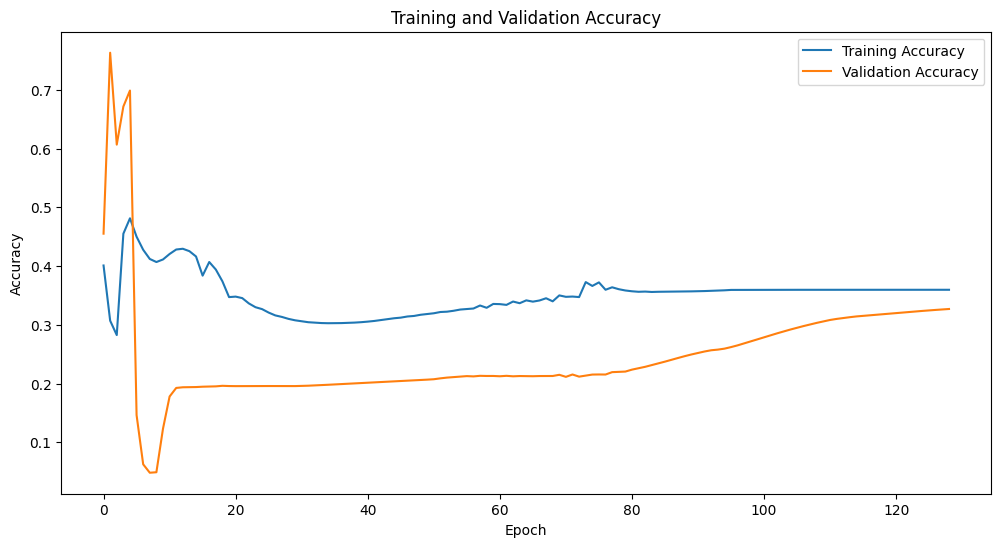

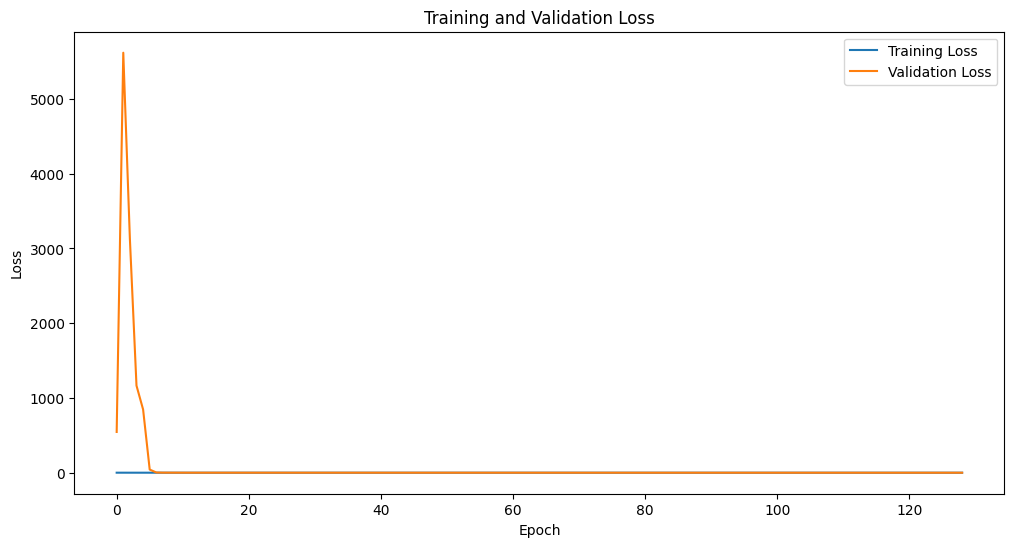

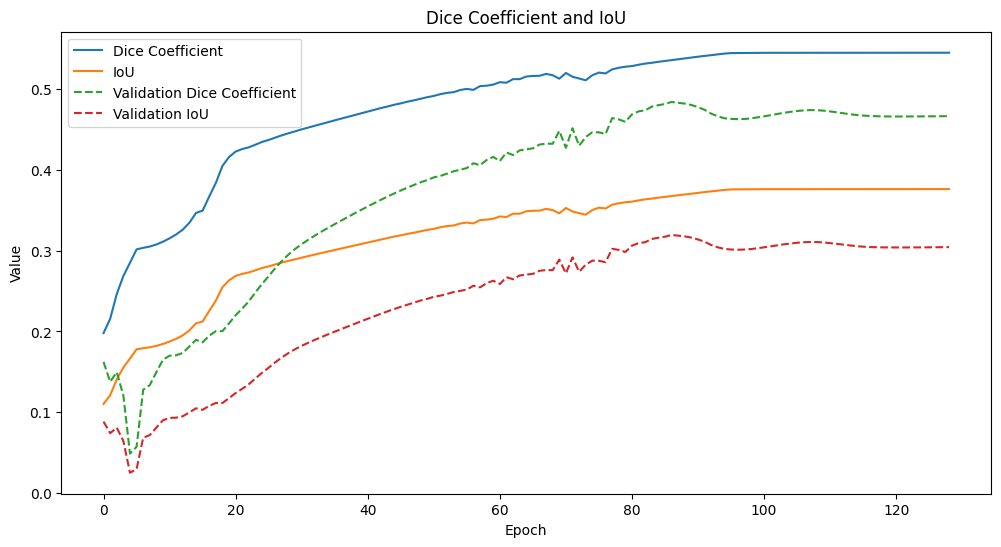

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('/content/mydrive/MyDrive/wound_detection/wdd_temp1/files/result/unetlogs.csv')

# Plot training and validation accuracy
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
ax.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy')
ax.legend()

# Plot training and validation loss
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['epoch'], data['loss'], label='Training Loss')
ax.plot(data['epoch'], data['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()

# Plot Dice coefficient and IoU
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['epoch'], data['dice_coef'], label='Dice Coefficient')
ax.plot(data['epoch'], data['iou'], label='IoU')
ax.plot(data['epoch'], data['val_dice_coef'], label='Validation Dice Coefficient', linestyle='--')
ax.plot(data['epoch'], data['val_iou'], label='Validation IoU', linestyle='--')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
ax.set_title('Dice Coefficient and IoU')
ax.legend()

plt.show()

1/1 [==============================] - 1s 621ms/step


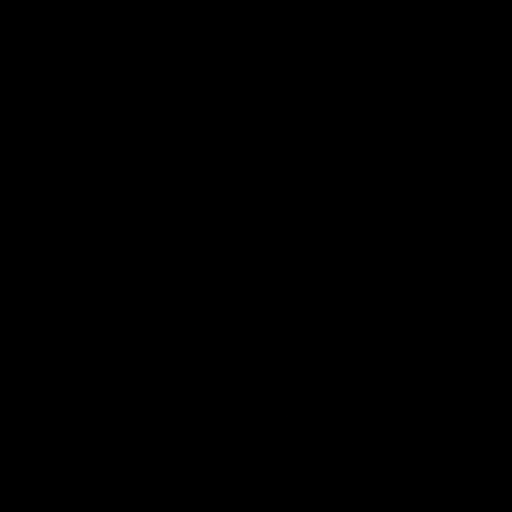

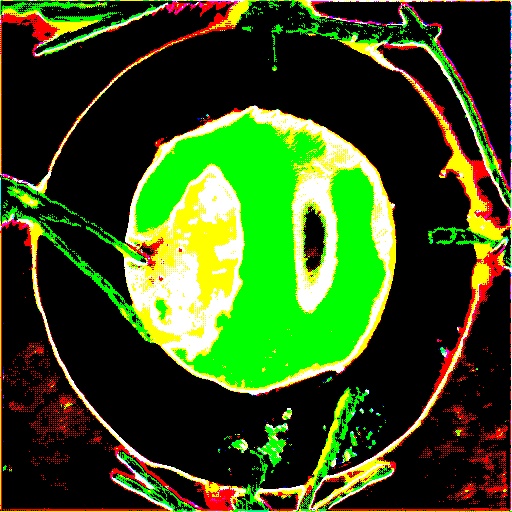

In [ ]:
# Define custom metric functions
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def iou(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

# Load the model with custom metric functions
model = tf.keras.models.load_model('/content/mydrive/MyDrive/wound_detection/wdd_temp1/files/result/unet2d.h5', custom_objects={'dice_coef': dice_coef, 'iou': iou})

# Read and preprocess the unseen image
unseen_image_path = '/content/mydrive/MyDrive/wound_detection/wdd_temp1/segmentation_train_data/test/images/20230924_183723.png'
unseen_image = cv2.imread(unseen_image_path)
unseen_image = cv2.resize(unseen_image, (512, 512))  # Assuming your model expects images of size 512x512
unseen_image = unseen_image / 255.0  # Normalize

# Make predictions
predictions = model.predict(np.expand_dims(unseen_image, axis=0))

# Post-process predictions if necessary
threshold = 0.1
binary_mask = predictions[0] > threshold

# Visualize the results
# Visualize the results
from google.colab.patches import cv2_imshow

cv2_imshow(unseen_image)
cv2_imshow(binary_mask.astype(np.uint8) * 255)
cv2.waitKey(0)
cv2.destroyAllWindows()
